In [1]:
%matplotlib inline

import time
import sys
import numpy as np
import skimage
from skimage import data, transform
import matplotlib.pyplot as plt
from skimage import io, exposure, img_as_uint, img_as_float
import pickle
import time
import math
import keras
from keras import *
from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from tempfile import TemporaryFile


Using TensorFlow backend.


In [2]:
outfile = TemporaryFile()
outfile2 = TemporaryFile()

In [2]:

encoding_dim = 4  # 4 angles are learned for 4 joints
decoding_dim = 19200 # Images are downsized to 210 * 120


# I had a black first image at first even though there was an image
n_samples = 10001
# Create n number of frames, for sequence for one angle
interpolation_steps = 4

with open('angles-observed.pkl', 'rb') as pickle_file:
    angles = pickle.load(pickle_file)
print("Loaded observed:" + str(len(angles)) + " angles")

lst_images = list()
lst_angles = list()

Loaded observed:40404 angles


In [4]:
for i in range(4, (len(angles) - 400)):
    # Load angles
    lst_angles.append(angles[i])
    image = skimage.io.imread('C:\\Users\\skork\\Documents\\img\\depth_' + str(i // 4) + "_" + str(i % 4) +  ".png" , as_grey=True)
    image_rescaled = skimage.transform.rescale(image, 1.0 / 4.0)
    lst_images.append(image_rescaled)


X = np.asarray(lst_images)
Y = np.asarray(lst_angles)


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
for i in range(5):
    np.random.seed(i)
    np.random.shuffle(X)
    np.random.seed(i)
    np.random.shuffle(Y)
   
    training, test = X[:32000,:], X[32000:40000,:]
    training_angle, test_angle = Y[:32000,:], Y[32000:40000,:]


In [65]:
angles_dim = 4  #  floats -> compression of factor 24.5, assuming the input is 784 floats

x_train = X.reshape((len(X), np.prod(X.shape[1:])))


input_img = Input(shape=(19200,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(19200, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (4-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_train, x_train))

Train on 40000 samples, validate on 40000 samples
Epoch 1/50
 4096/40000 [==>...........................] - ETA: 25s - loss: 0.6931

KeyboardInterrupt: 

In [15]:
x_train = training.reshape((len(training), np.prod(training.shape[1:])))
y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

x_test = test.reshape((len(test), np.prod(test.shape[1:])))
y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

modelEncoder = Sequential()
modelEncoder.add(Dense(1000, input_shape=(19200,)))
modelEncoder.add(Activation('relu'))
modelEncoder.add(Dense(1000, input_shape=(19200,)))
modelEncoder.add(Activation('relu'))
modelEncoder.add(Dense(100, input_shape=(1000,)))
modelEncoder.add(Activation('relu'))
modelEncoder.add(Dense(4))
modelEncoder.compile(loss='mean_squared_error', optimizer='Adam')
he = modelEncoder.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Train on 32000 samples, validate on 8000 samples
Epoch 1/100
11872/32000 [==========>...................] - ETA: 28s - loss: 0.0163

KeyboardInterrupt: 

In [6]:
x_train = training.reshape((len(training), np.prod(training.shape[1:])))
y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

x_test = test.reshape((len(test), np.prod(test.shape[1:])))
y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

modelDecoder = Sequential()
modelDecoder.add(Dense(100, input_shape=(4,)))
modelDecoder.add(Activation('relu'))
modelDecoder.add(Dense(1000, input_shape=(100,)))
modelDecoder.add(Activation('relu'))
modelDecoder.add(Dense(1000, input_shape=(1000,)))
modelDecoder.add(Activation('relu'))
modelDecoder.add(Dense(19200))
modelDecoder.compile(loss='mean_squared_error', optimizer='Adam')
modelDecoder.fit(y_train, x_train, epochs=100, validation_data=(y_test, x_test))

Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 51s 2ms/step - loss: 3.0750e-04 - val_loss: 1.5612e-04
Epoch 2/20
32000/32000 [==============================] - 46s 1ms/step - loss: 1.2765e-04 - val_loss: 1.0665e-04
Epoch 3/20
32000/32000 [==============================] - 46s 1ms/step - loss: 9.7094e-05 - val_loss: 8.7520e-05
Epoch 4/20
32000/32000 [==============================] - 46s 1ms/step - loss: 8.2653e-05 - val_loss: 7.6302e-05
Epoch 5/20
32000/32000 [==============================] - 47s 1ms/step - loss: 7.4045e-05 - val_loss: 7.0744e-05
Epoch 6/20
32000/32000 [==============================] - 47s 1ms/step - loss: 6.8190e-05 - val_loss: 6.4986e-05
Epoch 7/20
32000/32000 [==============================] - 46s 1ms/step - loss: 6.3599e-05 - val_loss: 6.2040e-05
Epoch 8/20
32000/32000 [==============================] - 47s 1ms/step - loss: 6.0251e-05 - val_loss: 5.8438e-05
Epoch 9/20
32000/32000 [=======================

In [16]:
he


NameError: name 'he' is not defined

In [96]:
test_angle.shape

(8000, 4)

In [97]:
y_test[0].shape

(4,)

In [7]:
output = modelDecoder.predict(y_test[0:])

In [8]:
a = output[0].reshape(120,160)

In [9]:
x_test[0]

array([0.12054431, 0.12054431, 0.12054431, ..., 0.        , 0.        ,
       0.        ])

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


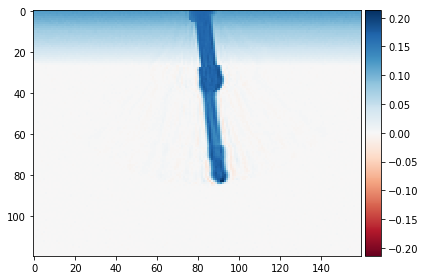

In [10]:
skimage.io.imshow(a)

In [11]:
b = x_test[0].reshape(120, 160)

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


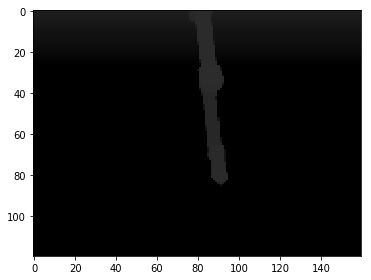

In [12]:
skimage.io.imshow(b)

In [107]:
np.save('X.dat', X)
np.save('Y.dat', Y)

In [13]:
output = None

In [17]:
# Final study 
# Histories
lst_he = list()
lst_hd = list()
for i in range(5):
    np.random.seed(i)
    np.random.shuffle(X)
    np.random.seed(i)
    np.random.shuffle(Y)
   
    training, test = X[:32000,:], X[32000:40000,:]
    training_angle, test_angle = Y[:32000,:], Y[32000:40000,:]
    x_train = training.reshape((len(training), np.prod(training.shape[1:])))
    y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

    x_test = test.reshape((len(test), np.prod(test.shape[1:])))
    y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

    modelEncoder = Sequential()
    modelEncoder.add(Dense(1000, input_shape=(19200,)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(1000, input_shape=(1000,)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(100, input_shape=(1000,)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(4))
    modelEncoder.compile(loss='mean_squared_error', optimizer='Adam')
    he = modelEncoder.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
    lst_he.append(he)
    
    modelDecoder = Sequential()
    modelDecoder.add(Dense(100, input_shape=(4,)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(1000, input_shape=(100,)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(1000, input_shape=(1000,)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(19200))
    modelDecoder.compile(loss='mean_squared_error', optimizer='Adam')
    hd = modelDecoder.fit(y_train, x_train, epochs=100, validation_data=(y_test, x_test))

    lst_hd.append(hd)


Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - 46s 1ms/step - loss: 0.0101 - val_loss: 0.0044
Epoch 2/100
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/100
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/100
32000/32000 [==============================] - 45s 1ms/step - loss: 9.0085e-04 - val_loss: 8.2680e-04
Epoch 7/100
32000/32000 [==============================] - 45s 1ms/step - loss: 7.8234e-04 - val_loss: 8.9047e-04
Epoch 8/100
32000/32000 [==============================] - 45s 1ms/step - loss: 6.9973e-04 - val_loss: 7.2952e-04
Epoch 9/100
32000/32000 [==============================] - 45s 1ms/step - loss:

Epoch 43/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.1646e-05 - val_loss: 3.1921e-05
Epoch 44/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.1169e-05 - val_loss: 3.1494e-05
Epoch 45/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.0961e-05 - val_loss: 3.1706e-05
Epoch 46/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.1058e-05 - val_loss: 3.1248e-05
Epoch 47/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.0890e-05 - val_loss: 3.0194e-05
Epoch 48/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.0241e-05 - val_loss: 3.1565e-05
Epoch 49/100
32000/32000 [==============================] - 46s 1ms/step - loss: 3.0171e-05 - val_loss: 3.0520e-05
Epoch 50/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.9941e-05 - val_loss: 2.9993e-05
Epoch 51/100
32000/32000 [==============================] - 46s 1ms/step - loss:

32000/32000 [==============================] - 44s 1ms/step - loss: 9.0882e-05 - val_loss: 2.2680e-04
Epoch 86/100
32000/32000 [==============================] - 44s 1ms/step - loss: 8.9035e-05 - val_loss: 2.5043e-04
Epoch 87/100
32000/32000 [==============================] - 44s 1ms/step - loss: 9.4781e-05 - val_loss: 2.0000e-04
Epoch 88/100
32000/32000 [==============================] - 44s 1ms/step - loss: 9.1558e-05 - val_loss: 2.2825e-04
Epoch 89/100
32000/32000 [==============================] - 44s 1ms/step - loss: 8.9235e-05 - val_loss: 1.9373e-04
Epoch 90/100
32000/32000 [==============================] - 44s 1ms/step - loss: 9.1041e-05 - val_loss: 1.8898e-04
Epoch 91/100
32000/32000 [==============================] - 44s 1ms/step - loss: 8.6104e-05 - val_loss: 2.3209e-04
Epoch 92/100
32000/32000 [==============================] - 44s 1ms/step - loss: 9.1090e-05 - val_loss: 2.4855e-04
Epoch 93/100
32000/32000 [==============================] - 44s 1ms/step - loss: 8.5181e-05 -

Epoch 56/100
32000/32000 [==============================] - 47s 1ms/step - loss: 2.9120e-05 - val_loss: 3.0411e-05
Epoch 57/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8772e-05 - val_loss: 3.0296e-05
Epoch 58/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8559e-05 - val_loss: 2.9153e-05
Epoch 59/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8392e-05 - val_loss: 2.9158e-05
Epoch 60/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8385e-05 - val_loss: 2.8718e-05
Epoch 61/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8201e-05 - val_loss: 2.9721e-05
Epoch 62/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.7945e-05 - val_loss: 2.9341e-05
Epoch 63/100
32000/32000 [==============================] - 46s 1ms/step - loss: 2.7865e-05 - val_loss: 2.8879e-05
Epoch 64/100
32000/32000 [==============================] - 46s 1ms/step - loss:

32000/32000 [==============================] - 45s 1ms/step - loss: 9.2246e-05 - val_loss: 1.8171e-04
Epoch 99/100
32000/32000 [==============================] - 45s 1ms/step - loss: 8.4754e-05 - val_loss: 1.9423e-04
Epoch 100/100
32000/32000 [==============================] - 45s 1ms/step - loss: 8.4004e-05 - val_loss: 2.3156e-04
Train on 32000 samples, validate on 8000 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[1000,19200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_8/Adam/mul_32 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_8/Adam/sub_2, training_8/Adam/gradients/dense_36/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_8/Adam/mul_32', defined at:
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\asyncio\base_events.py", line 1431, in _run_once
    handle._run()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-ec7aad955880>", line 40, in <module>
    hd = modelDecoder.fit(y_train, x_train, epochs=100, validation_data=(y_test, x_test))
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\models.py", line 963, in fit
    validation_steps=validation_steps)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\engine\training.py", line 1689, in fit
    self._make_train_function()
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\optimizers.py", line 461, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\ops\math_ops.py", line 907, in binary_op_wrapper
    return func(x, y, name=name)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1131, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 3100, in _mul
    "Mul", x=x, y=y, name=name)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1000,19200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_8/Adam/mul_32 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_8/Adam/sub_2, training_8/Adam/gradients/dense_36/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [20]:
tra_loss_encoding =  he.history['loss']
val_loss_encoding = he.history['loss']

In [42]:
!pip install plotly

  Using cached requests-2.18.4-py2.py3-none-any.whl
  Using cached urllib3-1.22-py2.py3-none-any.whl
  Using cached certifi-2018.1.18-py2.py3-none-any.whl
  Using cached idna-2.6-py2.py3-none-any.whl
  Using cached chardet-3.0.4-py2.py3-none-any.whl


Exception:
Traceback (most recent call last):
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pip\commands\install.py", line 342, in run
    prefix=options.prefix_path,
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pip\req\req_set.py", line 784, in install
    **kwargs
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pip\req\req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pip\req\req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packag

In [30]:
tra_loss_encoding =  he.history['loss']
val_loss_encoding = he.history['val_loss']

tra_loss_decoding =  hd.history['loss']
val_loss_decoding = hd.history['val_loss']

No handles with labels found to put in legend.
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


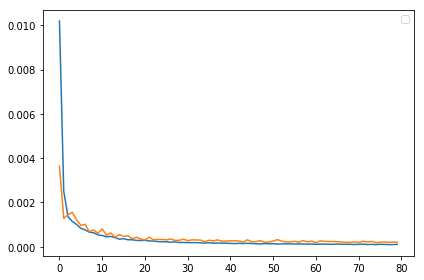

In [109]:
plt.plot(tra_loss_encoding[:80])
plt.plot(val_loss_encoding[:80])
plt.tight_layout()

plt.xlabel = "Number of Epochs"
plt.ylabel = "Loss"

plt.legend()


plt.show()

TypeError: 'str' object is not callable

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


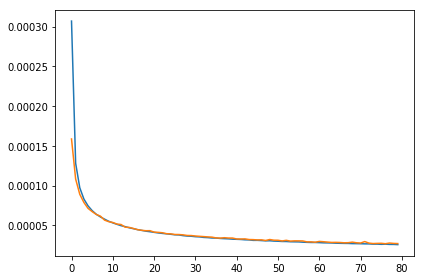

In [108]:
plt.plot(tra_loss_decoding[:80])
plt.plot(val_loss_decoding[:80])
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [102]:
import pickle
from matplotlib.pyplot import subplots, show
plt.gcf().subplots_adjust(bottom=0.15)


<Figure size 432x288 with 0 Axes>

In [105]:
file_object  = open("he.dat", "wb") 
pickle.dump(he, file_object,  protocol=4)

TypeError: can't pickle _thread.lock objects

In [41]:
file_object  = open("Y.dat", "wb") 
pickle.dump(Y, file_object , protocol=4)

In [77]:
plt.rc('figure', figsize=(15, 6))


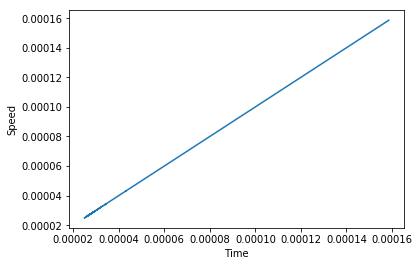

In [83]:
a = tra_loss_decoding
b = val_loss_decoding
fig, ax = subplots()
ax.plot(b, b)
ax.set_xlabel("Time")
ax.set_ylabel("Speed")
show()

In [104]:
import plotly.graph_objs as go
import plotly.offline as py

import numpy as np

data = [go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size='16',
        color = np.random.randn(500),
        colorscale='Viridis',
        showscale=True,
 line={width: 0.5}
    )
)]

layout = dict(
plot_bgcolor ='#F5F7FA',
   paper_bgcolor = '#F5F7FA',
   width = 500,
xaxis: {zeroline: false},
yaxis: {zeroline: false},
)

py.iplot( dict(data=data, layout=layout) )

SyntaxError: invalid syntax (<ipython-input-104-1327d3741ebc>, line 22)

In [119]:
lst = list()
for i in range(80):
    lst.append(i)
    
n_lst = np.asarray(lst)

<Figure size 864x288 with 0 Axes>

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


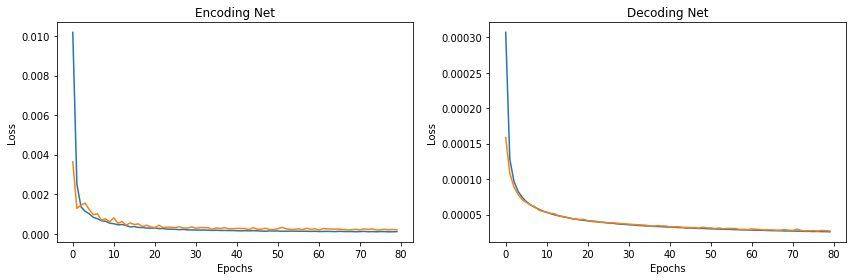

In [131]:
fig = plt.figure()  # an empty figure with no axes

fig, ax_lst = plt.subplots(1, 2)  # a figure with a 2x2 grid of Axes
ax_lst[0].set_xlabel('Epochs')
ax_lst[0].set_ylabel('Loss')
ax_lst[0].set_title("Encoding Net")
ax_lst[0].plot(n_lst, tra_loss_encoding[:80])
ax_lst[0].plot( n_lst, val_loss_encoding[:80])

ax_lst[1].set_xlabel('Epochs')
ax_lst[1].set_ylabel('Loss')
ax_lst[1].set_title("Decoding Net")
ax_lst[1].plot(n_lst, tra_loss_decoding[:80])
ax_lst[1].plot( n_lst, val_loss_decoding[:80])




In [2]:
X = pickle.load( open( "X.dat", "rb" ) )
Y = pickle.load( open( "Y.dat", "rb" ) )

In [6]:
# Histories
lst_ae = list()
for i in range(1):
    np.random.seed(i)
    np.random.shuffle(X)
    np.random.seed(i)
    np.random.shuffle(Y)
   
    training, test = X[:32000,:], X[32000:40000,:]
    training_angle, test_angle = Y[:32000,:], Y[32000:40000,:]
    x_train = training.reshape((len(training), np.prod(training.shape[1:])))
    y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

    x_test = test.reshape((len(test), np.prod(test.shape[1:])))
    y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

    modelAutoEncoder = Sequential()
    modelAutoEncoder.add(Dense(1000, input_shape=(19200,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(1000, input_shape=(19200,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(100, input_shape=(1000,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(4))
    modelAutoEncoder.add(Dense(100, input_shape=(4,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(1000, input_shape=(100,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(1000, input_shape=(1000,)))
    modelAutoEncoder.add(Activation('relu'))
    modelAutoEncoder.add(Dense(19200))
    modelAutoEncoder.compile(loss='mean_squared_error', optimizer='Adam')
    hae = modelAutoEncoder.fit(x_train, x_train, epochs=1, validation_data=(x_test, x_test))

    lst_ae.append(hae)


Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 91s 3ms/step - loss: 2.4410e-04 - val_loss: 1.2273e-04


In [60]:
#lst_he = list()
#lst_hd = list()

lst_neurons_ec = [1000, 1000, 100 ]
for i in range(1):
    np.random.seed(i)
    np.random.shuffle(X)
    np.random.seed(i)
    np.random.shuffle(Y)
   
    training, test = X[:32000,:], X[32000:40000,:]
    training_angle, test_angle = Y[:32000,:], Y[32000:40000,:]
    x_train = training.reshape((len(training), np.prod(training.shape[1:])))
    y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

    x_test = test.reshape((len(test), np.prod(test.shape[1:])))
    y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

    modelEncoder = Sequential()
    modelEncoder.add(Dense(lst_neurons_ec[0], input_shape=(19200,)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(lst_neurons_ec[1], input_shape=(lst_neurons_ec[0],)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(lst_neurons_ec[2], input_shape=(lst_neurons_ec[1],)))
    modelEncoder.add(Activation('relu'))
    modelEncoder.add(Dense(4))
    modelEncoder.compile(loss='mean_squared_error', optimizer='Adam')
    he = modelEncoder.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test))
    lst_he.append(he)
  


Train on 32000 samples, validate on 8000 samples
Epoch 1/80
32000/32000 [==============================] - 46s 1ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 2/80
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 3/80
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/80
32000/32000 [==============================] - 45s 1ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/80
32000/32000 [==============================] - 45s 1ms/step - loss: 9.4908e-04 - val_loss: 8.0523e-04
Epoch 6/80
32000/32000 [==============================] - 45s 1ms/step - loss: 8.4235e-04 - val_loss: 9.1050e-04
Epoch 7/80
32000/32000 [==============================] - 46s 1ms/step - loss: 8.0567e-04 - val_loss: 0.0011
Epoch 8/80
32000/32000 [==============================] - 45s 1ms/step - loss: 6.8190e-04 - val_loss: 9.3975e-04
Epoch 9/80
32000/32000 [==============================] - 45s 1ms/step - loss: 6.24

Epoch 73/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0691e-04 - val_loss: 1.8738e-04
Epoch 74/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.1060e-04 - val_loss: 1.8972e-04
Epoch 75/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0225e-04 - val_loss: 1.9442e-04
Epoch 76/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0152e-04 - val_loss: 1.8380e-04
Epoch 77/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0108e-04 - val_loss: 2.0939e-04
Epoch 78/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0302e-04 - val_loss: 1.9799e-04
Epoch 79/80
32000/32000 [==============================] - 45s 1ms/step - loss: 1.0087e-04 - val_loss: 2.0001e-04
Epoch 80/80
32000/32000 [==============================] - 45s 1ms/step - loss: 9.9804e-05 - val_loss: 1.7710e-04


In [26]:
lst_hd = list()

lst_neurons_ec = [10, 10, 4 ]
for i in range(1):
    np.random.seed(i)
    np.random.shuffle(X)
    np.random.seed(i)
    np.random.shuffle(Y)
   
    training, test = X[:32000,:], X[32000:40000,:]
    training_angle, test_angle = Y[:32000,:], Y[32000:40000,:]
    x_train = training.reshape((len(training), np.prod(training.shape[1:])))
    y_train = training_angle.reshape((len(training_angle), np.prod(training_angle.shape[1:])))

    x_test = test.reshape((len(test), np.prod(test.shape[1:])))
    y_test = test_angle.reshape((len(test_angle), np.prod(test_angle.shape[1:])))

 
    
    modelDecoder = Sequential()
    modelDecoder.add(Dense(lst_neurons_ec[2], input_shape=(4,)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(lst_neurons_ec[1], input_shape=(lst_neurons_ec[2],)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(lst_neurons_ec[0], input_shape=(lst_neurons_ec[1],)))
    modelDecoder.add(Activation('relu'))
    modelDecoder.add(Dense(19200))
    modelDecoder.compile(loss='mean_squared_error', optimizer='Adam')
    hd = modelDecoder.fit(y_train, x_train, epochs=80, validation_data=(y_test, x_test))

    lst_hd.append(hd)

Train on 32000 samples, validate on 8000 samples
Epoch 1/80
32000/32000 [==============================] - 12s 388us/step - loss: 5.1032e-04 - val_loss: 3.6558e-04
Epoch 2/80
32000/32000 [==============================] - 12s 367us/step - loss: 3.2314e-04 - val_loss: 2.9570e-04
Epoch 3/80
32000/32000 [==============================] - 12s 368us/step - loss: 2.8403e-04 - val_loss: 2.7415e-04
Epoch 4/80
32000/32000 [==============================] - 12s 371us/step - loss: 2.7102e-04 - val_loss: 2.6688e-04
Epoch 5/80
32000/32000 [==============================] - 12s 371us/step - loss: 2.6494e-04 - val_loss: 2.6204e-04
Epoch 6/80
32000/32000 [==============================] - 12s 370us/step - loss: 2.6132e-04 - val_loss: 2.5987e-04
Epoch 7/80
32000/32000 [==============================] - 12s 365us/step - loss: 2.5870e-04 - val_loss: 2.5698e-04
Epoch 8/80
32000/32000 [==============================] - 12s 372us/step - loss: 2.5682e-04 - val_loss: 2.5543e-04
Epoch 9/80
32000/32000 [=======

KeyboardInterrupt: 

In [6]:
# Composite loss
def myloss(mid_layer_output):
    encoder_loss = K.mean(K.square(y_pred[:19200] - y_true[:19200]), axis=-1)
    decoder_loss = K.mean(K.square(y_pred[19200:19203] - y_true[19200:19203]), axis=-1)
    loss = 0.5 * encoder_loss + 0.5 * decoder_loss 
    return loss 

SyntaxError: invalid syntax (<ipython-input-6-c57b28b15e1a>, line 5)

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


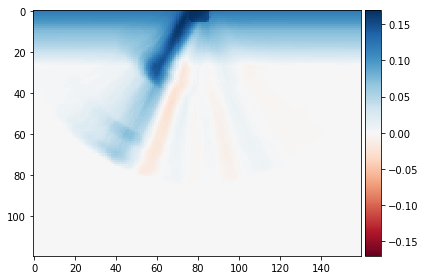

In [28]:
output = modelDecoder.predict(y_test[65:])
a = output[0].reshape(120,160)
skimage.io.imshow(a)

In [21]:
output = modelEncoder.predict(x_test[50:])
y_test[50]

array([-0.12586522,  0.47382617,  0.13221979,  0.05274391])

In [25]:
print(output)

[[-0.10507033 -0.14241403  0.16465406  0.01850457]
 [-0.09294368  0.08777469  0.03617337  0.00686596]
 [ 0.41592944  0.26867104  0.1422904   0.0169105 ]
 ...
 [ 0.15581112  0.13342488 -0.0033551   0.00658415]
 [-0.08735096 -0.4117399   0.2882646   0.03079036]
 [-0.06557208 -0.10615534 -0.23329352 -0.00706801]]


In [24]:
output = modelEncoder.predict(x_test[50:])
y_test[50]

array([-0.10683489, -0.13679099,  0.15617204,  0.11060357])

In [29]:
output = modelEncoder.predict(x_test)


In [45]:
residuals_angles  = y_test - output
residuals_angles.shape


(8000, 4)

In [55]:
print( np.std(residuals_angles[:,0]))
print( np.std(residuals_angles[:,1]))
print( np.std(residuals_angles[:,2]))
print( np.std(residuals_angles[:,3]))

0.01929314094723951
0.017995861544857692
0.022858273039013766
0.15588541865605715


In [58]:
output_100 = modelEncoder.predict(x_test)
residuals_angles_100  = y_test - output_100


In [59]:
print( np.std(residuals_angles_100[:,0]))
print( np.std(residuals_angles_100[:,1]))
print( np.std(residuals_angles_100[:,2]))
print( np.std(residuals_angles_100[:,3]))

0.010838231245972663
0.0073325866821590795
0.010660240100247893
0.024167100506210085


In [61]:
output_1000 = modelEncoder.predict(x_test)
residuals_angles_1000  = y_test - output_1000

print( np.std(residuals_angles_1000[:,0]))
print( np.std(residuals_angles_1000[:,1]))
print( np.std(residuals_angles_1000[:,2]))
print( np.std(residuals_angles_1000[:,3]))


0.010105911254186108
0.0075083836383580665
0.008749322495004864
0.020483169715784837


<Figure size 1080x432 with 0 Axes>

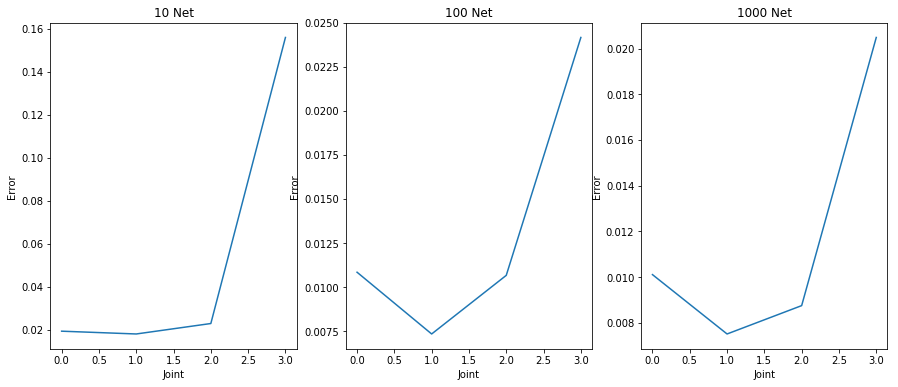

In [79]:
x = list()
y_10 = list()
y_100 = list()
y_1000 = list()
for i in range(4):
    x.append(i)
    y_10.append(np.std(residuals_angles[:,i]))
    y_100.append(np.std(residuals_angles_100[:,i]))
    y_1000.append(np.std(residuals_angles_1000[:,i]))

fig = plt.figure()  # an empty figure with no axes

fig, ax_lst = plt.subplots(1, 3)  # a figure with a 2x2 grid of Axes
ax_lst[0].set_xlabel('Joint')
ax_lst[0].set_ylabel('Error')
ax_lst[0].set_title("10 Net")
ax_lst[0].plot(x, y_10)

ax_lst[1].set_xlabel('Joint')
ax_lst[1].set_ylabel('Error')
ax_lst[1].set_title("100 Net")
ax_lst[1].plot(x,  y_100)

ax_lst[2].set_xlabel('Joint')
ax_lst[2].set_ylabel('Error')
ax_lst[2].set_title("1000 Net")
ax_lst[2].plot(x,  y_1000)




In [84]:
with open('.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(y_1000, f)
